# Virtual Pruning

## Importing the digitized structure

In [1]:
from openalea.mtg import *
from numpy import *
import numpy as np
from importlib import reload
import numpy as np
import mangoG3; reload(mangoG3)
from mangoG3 import *

g = get_G3_mtg()


In [2]:
from matplotlib.pyplot import *
import mtgplot as mp
reload(mp)


<module 'mtgplot' from '/Users/fboudon/Develop/oagit/virtualpruning/notebooks/mtgplot.py'>

In [3]:
sw = mp.plot_tree(g)
sw

SceneWidget(scenes=[{'id': 'tIR9t9s4HihZGOZOwFgI37lYo', 'data': b'x\xda\x9c}\x0b|U\xc5\xf1\xff\xe5\x8d\x97\x97…

### Diameter characterization

In [4]:
mp.plot_terminal_diameter(g, True, maxvalue=10)

SceneWidget(scenes=[{'id': 'x2kj1I89c1CgohFo7sii6weOa', 'data': b'x\xda\x94\x9d\x07\x9c\xd4T\xd7\x87\x97\x0eKG…

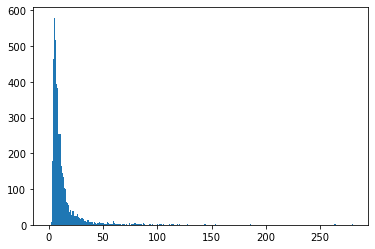

In [6]:
def terminal_diameter_histo(mtg):
    vids = [vid for vid in get_all_terminal_gus(mtg) if not was_previously_pruned(mtg,vid)]
    diam = list(map(lambda v : get_gu_diameter(mtg,v), vids))
    hist(diam, bins=range(int(max(diam)+1)))
    show()
    
terminal_diameter_histo(g)

In [7]:
from openalea.mtg.dataframe import to_dataframe
df = to_dataframe(g)

<AxesSubplot:>

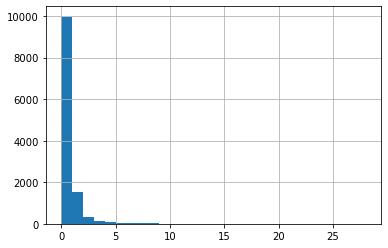

In [8]:
df['Diameter'][df['Diameter'].notna()].hist(bins=range(int(max(df['Diameter'])+1)))

In [9]:
print( max(map(lambda v : get_gu_diameter(g,v), get_all_gus(g))),0 )

280.0 0


In [10]:
thresholdradius = 10
bigterminalradiusvids = [vid for vid in get_all_terminal_gus(g) if not was_previously_pruned(g,vid) if get_gu_diameter(g,vid) > thresholdradius]
bigterminalradiusvids.sort(key = lambda vid : get_gu_diameter(g,vid))
print('Terminals with radius bigger than',thresholdradius,':',len(bigterminalradiusvids),bigterminalradiusvids)
print('Corresponding diameters :',list(map(lambda vid : get_gu_diameter(g,vid),bigterminalradiusvids)))
    

Terminals with radius bigger than 10 : 1626 [2012, 2575, 7439, 10789, 11725, 11737, 11808, 12939, 14068, 1310, 1701, 2656, 3495, 3651, 4086, 4223, 4451, 5799, 6046, 6632, 6682, 7035, 7989, 9025, 9356, 9533, 10282, 10589, 12178, 12182, 12189, 13031, 13250, 13370, 14822, 14883, 2444, 2448, 2455, 4448, 4918, 5009, 5843, 7654, 9065, 10648, 10943, 10947, 11794, 12747, 13998, 14034, 14232, 14930, 15461, 16409, 16659, 1064, 1410, 3625, 4419, 5279, 5510, 6750, 7050, 7111, 7783, 9706, 10399, 11192, 13249, 15366, 15367, 15744, 16077, 16112, 16116, 16123, 506, 1505, 2793, 2848, 2998, 3624, 3726, 3813, 5240, 5836, 5911, 6045, 6857, 7159, 7224, 7292, 7293, 7438, 7801, 9608, 10488, 10548, 10588, 11351, 11507, 11724, 12079, 12288, 12295, 12356, 12525, 12542, 12593, 12661, 13667, 13872, 14199, 14216, 14387, 14459, 14821, 15005, 15209, 16227, 16440, 1209, 1354, 1381, 1743, 2514, 5197, 6592, 6966, 7535, 8299, 11522, 13735, 13912, 13932, 16375, 1240, 1772, 3334, 4115, 4895, 5076, 5077, 5326, 5368, 6140, 

## Allometric relatrionships

In [11]:
from allometry import *

In [12]:
print('Volume :',volume(g), 'm3')
mbbx = bbox(g)
print([v[1]-v[0] for v in mbbx])

Volume : 67.26898110368 m3
[502.44, 490.4916666666667, 272.96]


## Pruning procedure

To select a pruning point, we start from terminal points, trace back into the structure up to 3 layers. We check if the pruning point is valid by looking the depth of what it carries. If it is in average close to what is intended we select it. Else we select another one.

Point d'amélioration : tailler en fait au milieu de la n4.

In [3]:
import pruning ; reload(pruning)
from pruning import *

In [5]:
t3 = prune(g, 200)
print(len(t3.property('pruned')))


600


In [4]:
potential_cutpoints = determine_potential_cutpoints(g, diameterconstraints = True)
#check_cutpoint_diameter_validity(g,potential_cutpoints)

# Characterize cut points


In [7]:
plot_pruning(g, potential_cutpoints, False, checkvalidity=False)

SceneWidget(scenes=[{'id': 'hwm5hthHhE7zWiQYYs6N213f7', 'data': b'x\xda|]\x07|T\xc5\xd6\x0f\x1d"\x9dPB\x0b\x1d…

In [17]:
def characterize_cut_points(mtg, listidpruned = potential_cutpoints):
    
    print('Diameters')
    figure(figsize=(18,4))
    for order, pruneds in listidpruned.items():
        subplot(130+order)
        d = [get_gu_diameter(mtg, vid) for vid in pruneds]
        md = int(5*ceil(max(d)/5))
        print(md,max(d))
        hist(d, bins=range(0,70,5)) #, bins=range(0,md,5))
        print(order,':',len(d),(np.mean(d), np.std(d)),(np.min(d), np.max(d)),diameterrange[order])
    show()
    
    print('Nb Descendants')
    figure(figsize=(18,4))
    for order, pruneds in listidpruned.items():
        subplot(130+order)
        d = [len(get_descendants_gus_from_ancestor(mtg, vid))-1 for vid in pruneds]
        hist(d,bins=arange(0.5,max(d)+0.51,1))
        print(order,':',len(d),(np.mean(d), np.std(d)))
    show()

    print('Nb Leaves')
    nbleaves = mtg.property('NbLeaf')
    figure(figsize=(18,4))
    for order, pruneds in listidpruned.items():
        subplot(130+order)
        d = [sum([nbleaves.get(lvid,0) for lvid in get_descendants_gus_from_ancestor(mtg, vid) if lvid != vid]) for vid in pruneds]
        hist(d) #,bins=arange(-0.5,max(d)+0.51,1))
        print(order,':',len(d),(np.mean(d), np.std(d)))
    show()

Diameters
20 17.0
1 : 1611 (6.22284295468653, 2.2522296531371366) (3.2, 17.0) (3.15, 17.2)
20 18.9
2 : 887 (7.920518602029312, 2.736666262785878) (4.4, 18.9) (4.32, 19.2)
25 21.400000000000002
3 : 519 (9.994605009633911, 3.400256392357886) (5.5, 21.400000000000002) (5.5, 22.09)


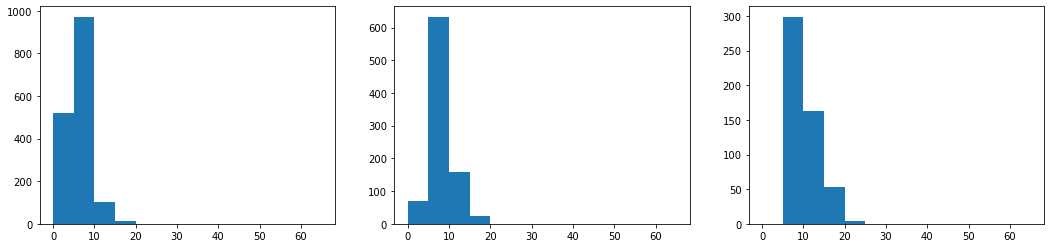

Nb Descendants
1 : 1611 (1.4245810055865922, 0.8898303258493854)
2 : 887 (3.419391206313416, 1.910626095241806)
3 : 519 (6.730250481695569, 3.7195093289628374)


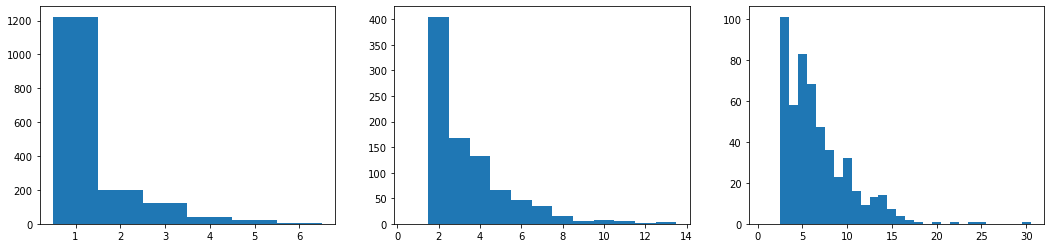

Nb Leaves
1 : 1611 (9.309124767225326, 7.512623593826679)
2 : 887 (20.482525366403607, 15.259553687473991)
3 : 519 (35.31791907514451, 27.17603157921005)


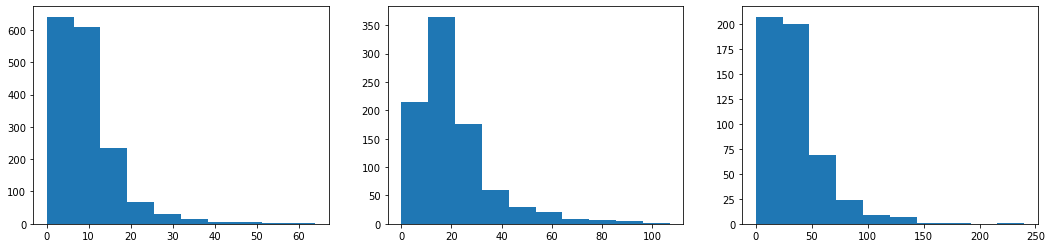

In [18]:
characterize_cut_points(g)

# Define pruning action

In [19]:
def test(mtg, nbcuts = 20):
    listidpruned = define_pruning(mtg, nbcuts, potential_cutpoints)
    assign_pruning(mtg, listidpruned)
    print(sum([len(p) for p in listidpruned.values()]))

    
    print('Diameters')
    figure(figsize=(18,4))
    for order, pruneds in listidpruned.items():
        if len(pruneds) > 0:
            subplot(130+order)
            d = [get_gu_diameter(mtg, vid) for vid in pruneds]
            hist(d)
            print ((np.mean(d), np.std(d)),(np.min(d), np.max(d)),diameterrange[order])
    show()
    
    print('Nb Descendants')
    figure(figsize=(18,4))
    for order, pruneds in listidpruned.items():
        if len(pruneds) > 0:
            subplot(130+order)
            d = [len(get_descendants_gus_from_ancestor(mtg, vid))-1 for vid in pruneds]
            hist(d,bins=arange(0.5,max(d)+0.51,1))
            print(np.mean(d), np.std(d))
    show()

    print('Nb Leaves')
    nbleaves = mtg.property('NbLeaf')
    figure(figsize=(18,4))
    for order, pruneds in listidpruned.items():
        if len(pruneds) > 0:
            subplot(130+order)
            d = [sum([nbleaves.get(lvid,0) for lvid in get_descendants_gus_from_ancestor(mtg, vid) if lvid != vid]) for vid in pruneds]
            hist(d) #,bins=arange(-0.5,max(d)+0.51,1))
            print(np.mean(d), np.std(d))
    show()
    return listidpruned


60
Diameters
(7.280000000000001, 2.963713886325736) (3.4000000000000004, 13.0) (3.15, 17.2)
(7.045, 1.8826776144629755) (4.4, 10.700000000000001) (4.32, 19.2)
(9.959999999999999, 2.5170220499630114) (6.5, 15.0) (5.5, 22.09)


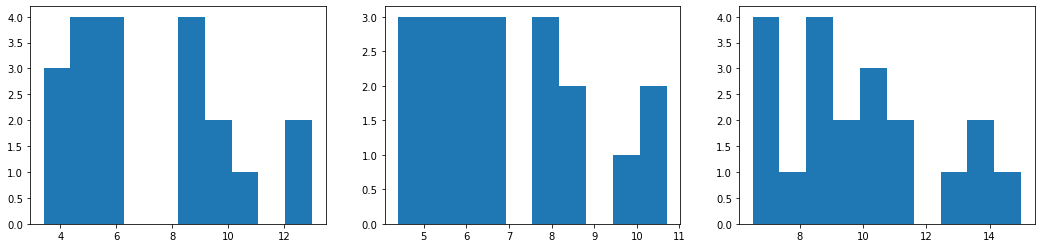

Nb Descendants
1.45 0.8046738469715542
3.4 1.4966629547095764
5.35 1.8513508581573617


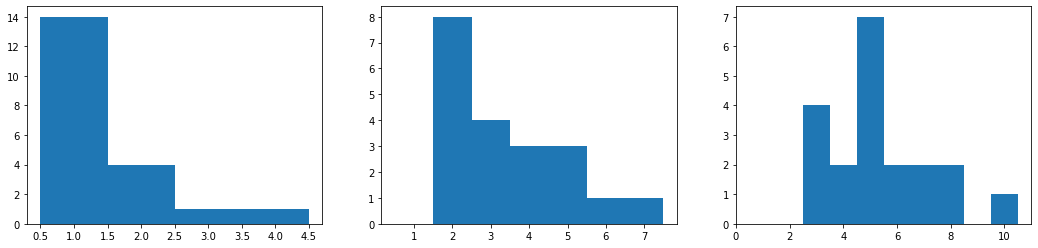

Nb Leaves
12.65 7.108269831681969
17.45 11.070117433884793
25.05 12.717999056455383


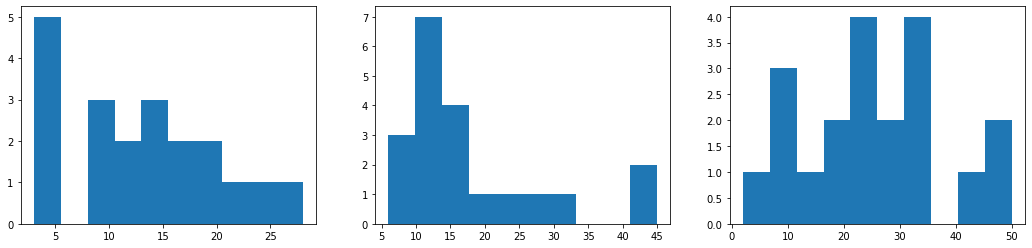

{1: [7502, 4236, 15575, 12013, 7706, 7837, 7273, 12718, 4093, 15115, 14314, 10707, 12663, 16193, 9986, 4258, 9054, 5068, 2695, 7318], 2: [9818, 1265, 8242, 9373, 5279, 6986, 8309, 2169, 8617, 7823, 5077, 12825, 15706, 13898, 12404, 1850, 11958, 4434, 14484, 7150], 3: [5430, 13912, 4660, 12478, 7535, 14802, 1635, 11853, 2623, 12344, 14064, 10547, 12695, 5196, 11585, 14498, 3302, 3839, 6266, 12940]}


In [20]:
listidprunedT1 = test(g,20)
print(listidprunedT1)

120
Diameters
(5.6125, 1.6554738747561073) (3.5, 10.0) (3.15, 17.2)
(8.3275, 2.792220218750663) (4.4, 17.3) (4.32, 19.2)
(9.48, 3.063592662218657) (5.699999999999999, 17.3) (5.5, 22.09)


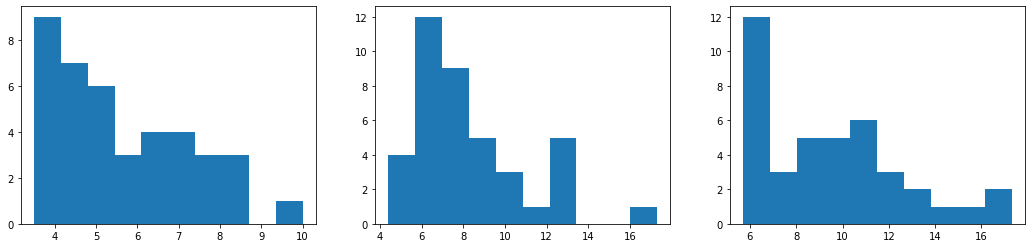

Nb Descendants
1.275 0.5910795208768445
3.575 1.7012862780849083
6.975 4.138160823361025


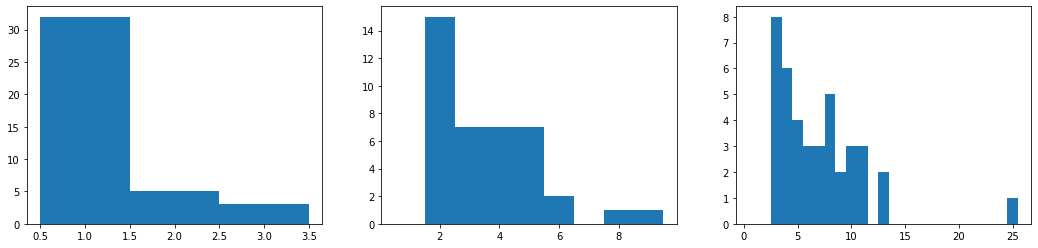

Nb Leaves
8.35 5.392355700433717
20.9 11.968291440301744
31.8 29.517113680033145


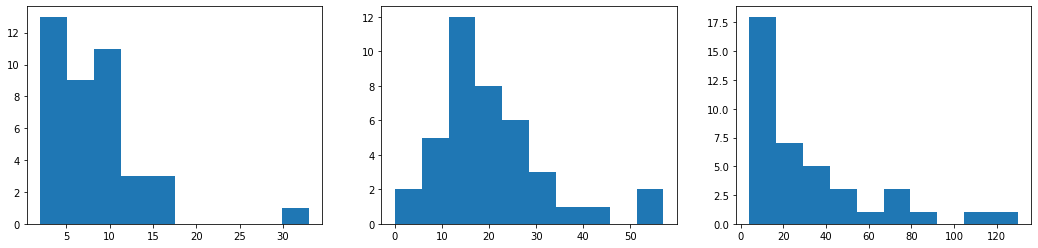

In [21]:
listidprunedT2 = test(g, 40)

180
Diameters
(6.178333333333333, 2.1763188849267676) (3.2, 15.8) (3.15, 17.2)
(7.325000000000001, 2.3473832949336018) (4.6000000000000005, 15.4) (4.32, 19.2)
(10.024999999999999, 3.6420976098946056) (5.5, 18.0) (5.5, 22.09)


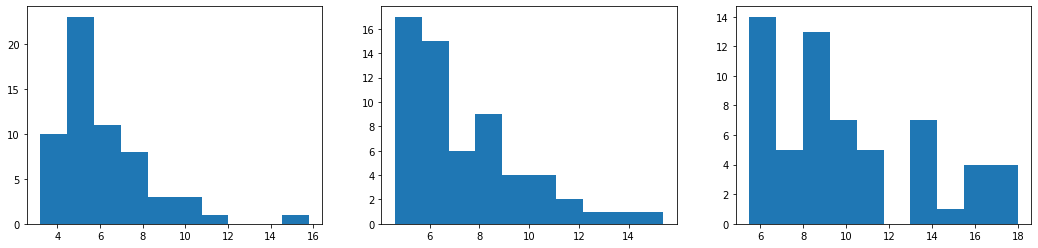

Nb Descendants
1.2833333333333334 0.6853628398317363
3.066666666666667 1.6918103387266028
6.783333333333333 3.979496059664953


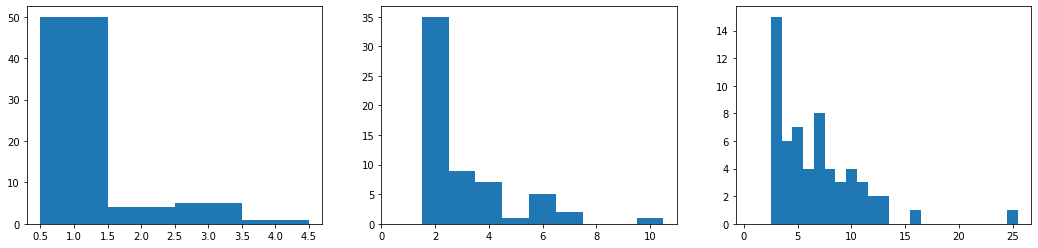

Nb Leaves
8.05 6.790741245745316
19.866666666666667 16.759541229467533
34.733333333333334 25.843030438054708


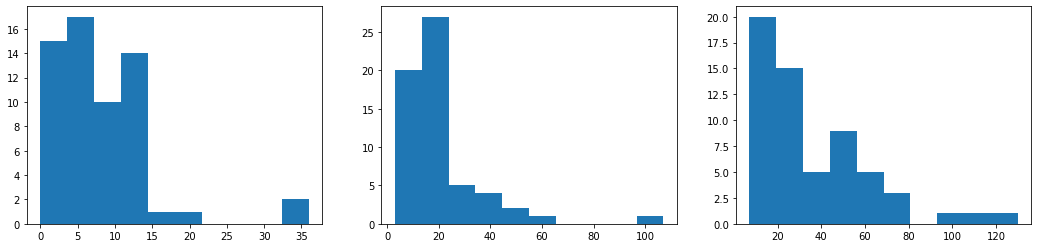

{1: [15881, 14624, 819, 2964, 15663, 15636, 5000, 9567, 15615, 15927, 7376, 11765, 16707, 3736, 9819, 9336, 2318, 12520, 1576, 10372, 5414, 1679, 2871, 13232, 8060, 3842, 13667, 8710, 2487, 14030, 13558, 4802, 15646, 6717, 9290, 11574, 2972, 7418, 5246, 9671, 3930, 6060, 14500, 6357, 16543, 11039, 741, 11922, 3082, 6546, 6581, 14529, 8842, 13604, 15320, 5403, 2827, 4258, 13989, 8229], 2: [5133, 13765, 7989, 6803, 16701, 7792, 10017, 12876, 7594, 12485, 14641, 10566, 2280, 4717, 35, 8461, 906, 15426, 5972, 3044, 3266, 14631, 15488, 16227, 4453, 6558, 9443, 14129, 5553, 5662, 4202, 4007, 482, 1909, 4365, 1864, 9611, 12009, 11376, 15760, 14163, 15519, 11143, 12671, 16360, 7429, 9499, 13150, 10282, 16271, 8672, 13200, 11608, 2562, 7856, 4503, 8824, 12382, 7025, 10416], 3: [12915, 10297, 11740, 5446, 12679, 15370, 1099, 14247, 12045, 5877, 3651, 7749, 14442, 6279, 15053, 4148, 11794, 1648, 14429, 975, 8177, 3772, 15243, 10197, 12783, 11156, 7050, 6592, 13439, 12422, 13418, 6811, 15939, 1185

In [22]:
listidprunedT3 = test(g, 60)
print(listidprunedT3)

200
Diameters
(10.03, 3.5005713819318127) (5.5, 20.7) (5.5, 22.09)


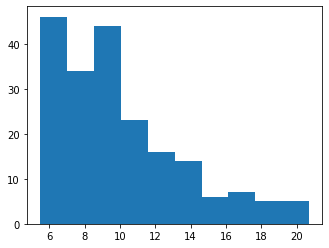

Nb Descendants
6.755 3.388948952108898


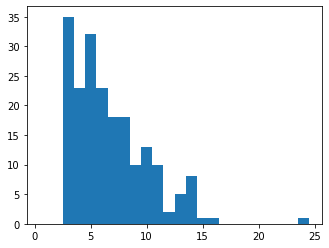

Nb Leaves
35.455 25.85996858080071


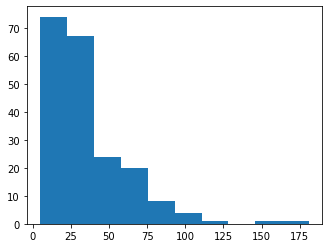

In [23]:
idprunedcustom = test(g,(0,0,200))

# Test summit condition

In [6]:
import pruning ; reload(pruning)
from pruning import *

In [7]:
summitalradius=100
pr = define_pruning(g,180,potential_cutpoints,summitratio = 0.4,summitalradius=summitalradius)

In [8]:
check_summital_ratio(g,pr,summitalradius=summitalradius)

0.3925925925925926

In [13]:
plot_pruning(g, pr, True, checkvalidity=False)

SceneWidget(scenes=[{'id': 'Pkqi8gn7rxyMcHJelBXSJdVAf', 'data': b'x\xda\xac\x9d\x07t\xd4\xc6\x16\x86\x8d\xe9\x…

In [9]:
pruned = apply_pruning(g, pr)

In [10]:
import gapfraction; reload(gapfraction)
from gapfraction import *

0.2778940832782762


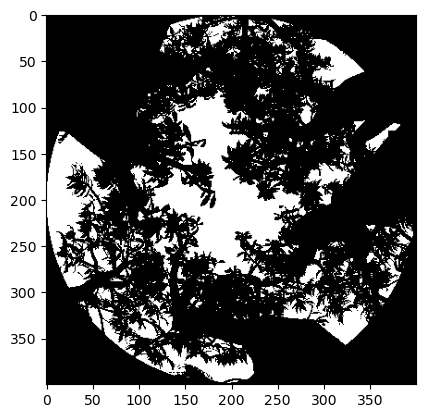

In [11]:
img = hemispherical_view(pruned, debug=True)
print(gap_fraction_from_image(img))
imshow(img)

### Preliminary analysis

Diameters of n2 and n3 are very similars. Measured values range more at 7, 9.5, 13 for n1, n2 and n3 respectivelly.

With rule of cut points for stricts n1, n2, n3, n1 are always composed of only 1 GU. It means that no configuration with several daughters at the same points with no children each exists in the digitized structure.

## Pruning Characterization

### intensité de taille en variable continue
attention, l'intensité de taille correspond à la biomasse/volume et non la surface foliaire/volume

In [24]:
def pruned_biomass_analysis(mtg, listprunedgu): 
    diameters = [[get_gu_diameter(mtg,vid) for vid in nis] for nis in listprunedgu.values()]
    biomasses = [sum(list(map(gu_biomass, diam)))/1000 for diam in diameters]
    biomass = sum(biomasses)

    print("biomasse totale retirée:",round(biomass,2),"kg")
    print("biomasse n1:",round(biomasses[0],2),"kg - diameters :", np.mean(diameters[0]), '+-', np.std(diameters[0]), ' (6.9+-1.6)')
    print("biomasse n2:",round(biomasses[1],2),"kg - diameters :", np.mean(diameters[1]), '+-', np.std(diameters[1]), ' (9.5+-2.5)')
    print("biomasse n3:",round(biomasses[2],2),"kg - diameters :", np.mean(diameters[2]), '+-', np.std(diameters[2]), ' (13.1+-3.4)')


### intensité de taille catégorielle: T0, T1, T2 ou T3

In [19]:
cT1 = continuous_intensity(g,listidprunedT1)
pruned_biomass_analysis(g,listidprunedT1)
print("intensité de taille",  cT1, intensity_level(cT1))
print()

cT2 = continuous_intensity(g,listidprunedT2)
pruned_biomass_analysis(g,listidprunedT2)
print("intensité de taille", cT2, intensity_level(cT2))
print()

cT3 = continuous_intensity(g,listidprunedT3)
pruned_biomass_analysis(g,listidprunedT3)
print("intensité de taille", cT3, intensity_level(cT3))

NameError: name 'gu_biomass' is not defined

## Caracterizing cut

### We calculate the mean number of terminal GUs according to pruning severity

In [25]:
def nbterminals(mtg, listcutids):
    nb_term = [len(get_terminal_gus_from_ancestor(mtg, vid)) for vid in listcutids]
    return (round(np.mean(nb_term),2), round(np.std(nb_term),2))

In [26]:
id_n1, id_n2, id_n3 = potential_cutpoints.values()
print(nbterminals(g,id_n1))
print(nbterminals(g,id_n2))
print(nbterminals(g,id_n3))

(1.42, 0.89)
(2.22, 1.6)
(3.67, 2.56)


### We calculate the number of leaves above the pruning point according to pruning severity

In [27]:
def nbleaves_prunedGU(mtg, listcutids):
    d = [sum([get_gu_nb_leaf(mtg, lvid) for lvid in get_descendants_gus_from_ancestor(mtg, vid) if lvid != vid]) for vid in listcutids]
    return (round(np.mean(d)),round(np.std(d)))

In [28]:
print(nbleaves_prunedGU(g,id_n1))
print(nbleaves_prunedGU(g,id_n2))
print(nbleaves_prunedGU(g,id_n3))

(9, 8)
(20, 15)
(35, 27)


### calculation of leaf area from diameter

In [29]:
def leafarea(mtg,listcutids):
    leaf_area = [gu_leaf_area(get_gu_diameter(mtg, vid)) for vid in listcutids]
    #leaf_area = [gu_leaf_area(get_gu_section(mtg, vid)) for vid in listcutids]
    return ((np.mean(leaf_area)),(np.std(leaf_area)))    

In [30]:
print(leafarea(g,id_n1))
print(leafarea(g,id_n2))
print(leafarea(g,id_n3))

(5.736924355520457, 5.30669661646603)
(9.587575585527293, 8.106319373503608)
(15.865749886983163, 12.640102384793384)


## Estimation of gap fraction 

In [31]:
import gapfraction; reload(gapfraction)
from gapfraction import *

D:\V_mango\virtualpruning\notebooks\povray
D:\MesProgrammes\POV-Ray\v3.7\bin\pvengine.exe /EXIT /RENDER gapfraction_view.pov -Ogapfraction_view.png +H400 +W400 +FN -GA -A
Done in 4.145103931427002 sec.


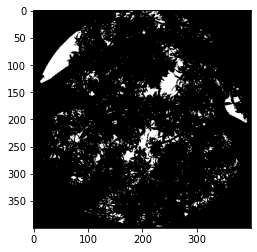

In [32]:
from matplotlib.pyplot import imshow
img = generate(g, camheight=150, debug=True)
imshow(img)

In [33]:
gf = gap_fraction(g, camheight=120)
print(gf)

0.10477736401540469


In [34]:
t3 = prune(g, 200)


ValueError: (1823, [1824])

In [ ]:
print(len(t3.property('pruned')))

In [35]:
plot_pruning(t3, leaves=True)

NameError: name 't3' is not defined

In [36]:
img = generate(t3, size = 400, camheight=150, debug=True)
imshow(img)

NameError: name 't3' is not defined

In [37]:
a = img[np.where(img>0)].sum()
b= 96142140
print(a,b,a/b)

8363745 96142140 0.08699353894140488


In [38]:
print(gap_fraction(t3, size = 400, camheight=150, debug=False))

NameError: name 't3' is not defined

In [39]:
def info(mtg):
    return (continuous_intensity_from_pruned(mtg), gap_fraction(mtg))
nbcuts = list(range(1,401, 10))
gfs = [info(prune(g,nc)) for nc in nbcuts]

ValueError: (7936, [7937])

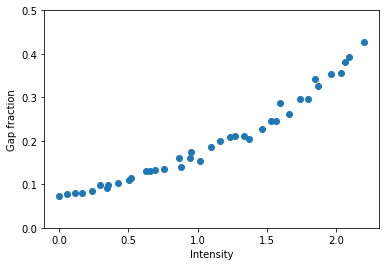

In [41]:
ylim(0,0.5)
scatter([a[0] for a in gfs],[a[1] for a in gfs])
xlabel('Intensity')
ylabel('Gap fraction')
show()

In [42]:
print(info(prune(g,1)))

(0.007282819830671908, 0.07128648270155001)


## Application of pruning

In [40]:
t3 = apply_pruning(g, listidprunedT3)
print(t3.property('pruning'))
print(t3.property('cuted'))
print(len(g), len(t3))
mp.plot_tree(t3,leaves= True)


ValueError: (15881, [15882])


# Vegetative growth after pruning

In [46]:
from numpy.random import binomial, poisson, uniform, normal
import sys

def binomial_proba(intercept, slope, factor):
    linear = intercept +slope*factor
    return exp(linear)/(1+exp(linear))

def binomial_realization(proba):
    return bool( binomial(1,proba) )

def poisson_proba(intercept, slope, factor):
    return exp(intercept+slope*factor)

def poisson_realization(proba, maxval = sys.maxsize, minval = 0):
    assert maxval > minval
    val = int( poisson(proba, 1) )
    count = 0
    while (val < minval) or (val > maxval):
        count += 1
        if count >= 1000:
            raise ValueError(proba, maxval, minval)
        val = int( poisson(proba, 1) )
    return val

def normal_realization(mean, sd, maxval = sys.float_info.max, minval = sys.float_info.min):
    assert maxval > minval
    val = normal(mean, sd)
    count = 0
    while (val < minval) or (val > maxval):
        count += 1
        if count >= 1000:
            raise ValueError(mean, sd, maxval, minval, val)
        val = normal(mean, sd)
    return val

In [47]:
 def lateral_directions(maindir, angle, nb):
    from math import pi
    from openalea.plantgl.all import direction, Matrix3
    assert nb >= 1
    rotdir = direction(maindir.anOrthogonalVector())
    rotmat = Matrix3.axisRotation(rotdir, radians(angle))
    v0 = rotmat * maindir
    deltahangle = 2*pi/nb
    result = [v0] + [Matrix3.axisRotation(maindir, i * deltahangle) *v0 for i in range(1,nb)]
    return result


In [48]:
def create_daughters(mtg, vid, apical, nblateral, burstdate, totalleafarea = None,  individualleafarea = None):
    parentdirection = get_gu_normed_direction(mtg, vid)
    topposition = get_gu_top_position(mtg, vid)
    diam = get_gu_diameter(mtg, vid)
    newgus = []
    # newconnections = []
    lengths = []
    if not totalleafarea is None:
        set_gu_property(mtg, vid, "RegeneratedLeafArea", totalleafarea)

    if apical:
        apicaldaughter = mtg.add_child(vid, edge_type = '<', UnitType = 'U', label = 'S'+str(int(mtg.label(vid)[1:])+1))        
        l = gu_length(eApical, gu_position(mtg, vid) )
        set_gu_top_position(mtg, apicaldaughter, topposition + parentdirection * l )
        set_gu_diameter(mtg, apicaldaughter, diam)
        newgus.append(apicaldaughter)
        lengths.append(l)
        set_gu_property(mtg, apicaldaughter, "Regrowth", True)
        set_gu_property(mtg, apicaldaughter, "BurstDate", burstdate)
        
    branching_angle = 60
    if nblateral > 0:
        for latiter, latdirection in enumerate(lateral_directions(parentdirection, branching_angle, nblateral)):
            lateralconnection = mtg.add_child(vid, edge_type = '+', label = 'S1', Position = topposition, UnitType = 'U')
            lateraldaughter   = mtg.add_child(lateralconnection, edge_type = '<', label = 'S2', UnitType = 'U', Diameter=diam/10.)
            l = gu_length(eLateral, gu_position(mtg, vid) )
            set_gu_top_position(mtg, lateraldaughter, topposition + latdirection * l )
            set_gu_diameter(mtg, lateraldaughter, diam)
            # newconnections.append(lateralconnection)
            newgus.append(lateraldaughter)
            lengths.append(l)
            set_gu_property(mtg, lateraldaughter, "Regrowth", True)
            set_gu_property(mtg, lateraldaughter, "BurstDate", burstdate)
            #print(get_gu_top_position(mtg, lateraldaughter),get_gu_bottom_position(mtg, lateraldaughter), get_gu_diameter(mtg, lateraldaughter))

    totlength = sum(lengths)
    if not totalleafarea is None and totalleafarea > 0:
        unitla = totalleafarea / totlength
        for vid, l in zip(newgus, lengths):
            leafarea = unitla*l
            set_gu_property(mtg, vid, "LeafArea", leafarea)
            if not individualleafarea is None:
                set_gu_property(mtg, vid, "NbLeaf", int(round(leafarea / individualleafarea)))
    
    return newgus
        


In [49]:
def gu_length(position, motherposition):
    gu_length_distrib = { (eApical, eApical)   : ( 18.14 , 4.14 ) ,
                          (eApical, eLateral)  : ( 13.79 , 4.03 ) ,
                          (eLateral, eApical)  : ( 12.59 , 3.38 ) ,
                          (eLateral, eLateral) : ( 12.59 , 3.38 ) }
    mean, sd = gu_length_distrib[(position, motherposition)]
    return normal_realization(mean, sd, 25, 5)

def gu_nb_leaf(position):
    leaf_nb_distrib = { eApical  : ( 0.59, 5.5), eLateral : ( 0.62, 0.36) }
    return normal_realization(*leaf_nb_distrib[position])
    
def burst_pruned(intensity, diameter):
    probas = { T1 : (-2.479643,0.29399), 
               T3 : (-1.284197,0.29399) }
    intercept, slope = probas[intensity]
    probavalue = binomial_proba(intercept,slope,diameter)
    return binomial_realization( probavalue)

def nb_daughter_pruned(intensity, diameter):
    probas = (-0.1563453, 0.09122709)
    intercept, slope = probas
    probavalue = poisson_proba(intercept,slope,diameter)
    try:
        return poisson_realization( probavalue, 10)+1
    except ValueError as ve:
        print(diameter)
        raise ve

def total_leafarea_pruned(intensity, diameter):
    """ Total leaf area generated from a pruned gu in dm2 """
    probas = (0,0.6351646,4.978825)
    intercept, slope,sd = probas
    probavalue = slope*diameter+intercept
    minval=0.1 
    maxval=28
    return  normal_realization(probavalue, sd, maxval, minval)

def individual_leafarea_pruned(intensity):
    """ Individual leaf area of GU borned from a pruned GU in dm2 """
    probas = { T1 : (47.1,25.9), 
               T3 : (62.3,21.1) }
    probavalue, sd = probas[intensity]
    minval=6 
    maxval=150
    return  normal_realization(probavalue, sd, maxval, minval)/100.
    

def burst_unpruned(intensity, diameter, apical_bud):
    if apical_bud==True:
        probas = { T0 : (-2.769854, 0.5973448),
                   T1 : (-2.425214  , 0.5973448), 
                   T3 : (-1.559723 , 0.5973448) }
        intercept, slope = probas[intensity]
        probavalue = binomial_proba(intercept,slope,diameter)
    else:
        probas = { T0 : (-4.143407, 0.5973448),
                   T1 : (-3.798768  , 0.5973448), 
                   T3 : (-2.933276  , 0.5973448) }
        intercept, slope = probas[intensity]
        probavalue = binomial_proba(intercept,slope,diameter)
    return binomial_realization( probavalue)

def nb_daughter_unpruned(intensity, diameter, apical_bud):
    if apical_bud :
        probas = { T0 : (-5.563934, 0.4102305),
                   T1 : (-4.807413, 0.4102305), 
                   T3 : (-4.821,    0.4102305) }
    else:
        probas = { T0 : (-2.775646, 0.4102305),
                   T1 : (-2.019124, 0.4102305), 
                   T3 : (-2.032712, 0.4102305) }
    intercept, slope = probas[intensity]
    probavalue = poisson_proba(intercept,slope,diameter)
    try:
        return poisson_realization( probavalue, 10)+1
    except ValueError as ve:
        print(intensity, diameter, apical_bud)
        raise ve

def total_leafarea_unpruned(intensity, diameter, apical_bud):
    """ Total leaf area generated from a pruned gu in dm2 """
    if apical_bud :
        probas = { T0 : (-0.3099147, 0.6698266,2.205946),
                   T1 : (0.863612 ,0.6698266,2.342514), 
                   T3 : (2.579996, 0.6698266,2.458084) }
    else:
        probas = { T0 : (-1.913821, 0.6698266,2.361798),
                   T1 : (-0.740294 ,0.6698266,2.342514), 
                   T3 : (2.579996, 0.6698266,1.290018) }
        
    intercept, slope,sd = probas[intensity]
    probavalue = slope*diameter+intercept
    minval=0.1
    maxval=20
    return  normal_realization(probavalue, sd, maxval, minval)

def individual_leafarea_unpruned(intensity):
    """ Individual leaf area of GU borned from an unpruned GU in dm2 """
    probas = { T0 : (37.9,18.7), 
               T1 : (49.6,26.4), 
               T3 : (70.4,29.03) }
    probavalue, sd = probas[intensity]
    minval=6
    maxval=150
    return  normal_realization(probavalue, sd, maxval, minval)/100.
 

def burstdelay_pruned(intensity,  severity):
    minval = 10
    
    if intensity == T1 :
        
        flushproba = { 1  : 0.28, 2 : 0.69, 3 : 0.64}
        firstflush = binomial_realization(flushproba[severity])
        
        if firstflush : # Correspond to first flush
            probas = { 1 : (14.7, 1.5) ,
                       2 : (19.4, 2.9), 
                       3 : (17.8, 2.1) }
        else:
            probas = { 1 : (28.2, 3.9),
                       2 : (28.3, 0.7), 
                       3 : (28.3, 2.0) }
        mean, sd = probas[severity]
        maxval = 40
        
    if intensity== T3 :
        mean, sd = 16.5, 2.6
        maxval = 30
    
    return normal_realization(mean, sd, maxval, minval)
    
def flush_selection_unpruned(intensity):
    if intensity == T0 :
        firstflushproba = 0.85
    elif intensity == T1 :
        firstflushproba = 0.48        
    return binomial_realization(firstflushproba)

def burstdelay_unpruned(intensity):
    minval = 10
    maxval = 35
    
    if intensity == T0 :
        firstflush = flush_selection_unpruned(intensity)
        if firstflush :
            mean, sd = 13.4, 3.0
        else:
            mean, sd = 27.5, 1.1
    if intensity == T1:
        firstflush = flush_selection_unpruned(intensity)
        if firstflush :
            mean, sd = 13.5, 2.0
        else:
            mean, sd = 27.5, 1.1
        
    if intensity == T3:
        mean, sd = 16.5, 2.6
        maxval = 25
        
    return  normal_realization(mean, sd, maxval, minval)


In [53]:
from datetime import date, timedelta

def growth_pruned_gu(mtg, vid, intensity, severity, pruningdate):
    diameter = get_gu_diameter(mtg, vid)
    veggrowth = burst_pruned(intensity, diameter)
    if veggrowth:
        nbdaughter = nb_daughter_pruned(intensity, diameter)+1
        assert nbdaughter >= 1
        totalleafarea = total_leafarea_pruned(intensity, diameter)
        individualleafarea = individual_leafarea_pruned(intensity)
        burstdate = pruningdate + timedelta(days = burstdelay_pruned(intensity,  severity))
        return create_daughters(mtg, vid, 0, nbdaughter, burstdate, totalleafarea, individualleafarea)       


def growth_unpruned_gu(mtg, vid, intensity, pruningdate):
    diameter = get_gu_diameter(mtg, vid)
    apical_bud = binomial_realization(0.52)
    veggrowth = burst_unpruned(intensity, diameter, apical_bud)
    if veggrowth:
        nbdaughter = nb_daughter_unpruned(intensity, diameter, apical_bud)
        assert nbdaughter >= 1
        totalleafarea = total_leafarea_unpruned(intensity, diameter, apical_bud)
        individualleafarea = individual_leafarea_unpruned(intensity)
        burstdate = pruningdate + timedelta(days = burstdelay_unpruned(intensity))
        return create_daughters(mtg, vid, int(apical_bud), nbdaughter-int(apical_bud), burstdate, totalleafarea, individualleafarea)

import util ; reload(util)
from util import *
from copy import deepcopy

def growth(mtg, listidpruned, intensity, pruningdate = date(2017,2,1), maxdiamunpruned = 10):
    newmtg = deepcopy(mtg)
    listidpruned = dict([(ni, set(ids)) for ni,ids in listidpruned.items() ])
    terminals = get_all_terminal_gus(mtg)
    nbterminals = len(terminals)
    newids = []
    print("Should examine", nbterminals, "terminal GUs.")
    nbpruned, nbunpruned, nbignored = 0,0,0
    for count, vid in enumerate(terminals):
        pruned = False
        lnewids = None
        for severity, ids in listidpruned.items():
            if vid in ids:
                # we consider a pruned gu:
                lnewids = growth_pruned_gu(newmtg, vid, intensity, severity, pruningdate)
                nbpruned += 1
                pruned = True
                break
        if not pruned and get_gu_diameter(mtg, vid) <= maxdiamunpruned and not 'A'in mtg.property('Taille').get(vid,''):
            nbunpruned += 1
            lnewids = growth_unpruned_gu(newmtg, vid, intensity, pruningdate)
        elif not pruned:
            nbignored += 1
        if lnewids:
            newids += lnewids
    print("Processed", nbpruned, "pruned terminal GU and", nbunpruned, "unpruned terminal GU and ", nbignored, "ignored.")
    return newmtg, newids
    

In [54]:
class GrowthColoring: 
    def __init__(self, newids):
        self.newids = set(newids)
    def prepare_turtle(self, turtle):
        from openalea.plantgl.all import Material
        turtle.setMaterial(1,Material((45,65,15))) # ,transparency=0.8))
        turtle.setMaterial(10,Material((200,200,0)))
        turtle.setMaterial(11,Material((200,0,0)))
    def set_mtg(self, mtg):
        self.mtg = mtg            
        self.colors = { False : 1, True : 2}
        self.mindate = min(self.mtg.property('BurstDate').values()) #date(2017,2,1)
        self.maxdate = max(self.mtg.property('BurstDate').values()) #date(2017,6,1)
        print(self.mindate, self.maxdate)
        self.deltadate = float((self.maxdate - self.mindate).days)
    def __call__(self, turtle, vid):
        if vid in self.newids:
            d = (get_gu_property(self.mtg, vid, "BurstDate")-self.mindate).days
            turtle.interpolateColors(10,11,d/self.deltadate)
        else:
            turtle.setColor(1)



In [56]:
gt3, newids = growth(t3, listidprunedT3, T3)
print('Created', len(newids), 'new GUs')
mp.plot_tree(gt3, colorizer = GrowthColoring(newids), leaves=True, gc = False)

Should examine 4060 terminal GUs.
Processed 0 pruned terminal GU and 2462 unpruned terminal GU and  1598 ignored.
Created 4673 new GUs
2017-02-11 2017-02-25


SceneWidget(scenes=[{'id': '7ibHdaoHgcL8XAB1gYq2fVzFh', 'data': b'x\xda\x94\x9d\x05|\x14\xc7\x1e\xc7\x83\xbb\x…

In [57]:
def date_histo(g):
    from matplotlib.pyplot import hist, show
    from collections import Counter
    from datetime import timedelta
    c = list(Counter(g.property('BurstDate').values()).items())
    c.sort(key = lambda v : v[0])
    mindate = c[0][0]
    maxdate = c[-1][0]
    c = dict(c)
    r = range(0,(maxdate-mindate).days)
    d = [mindate+timedelta(days=d) for d in r]
    v = [ c.get(di,0) for di in d]
    bar(r,v)
    xticks(r,d, rotation=90)
    show()

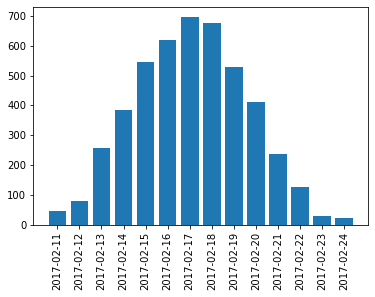

In [58]:
date_histo(gt3)

In [59]:
def nb_children_histo(g):
    def severity(vid):
        return g.property('cuted').get(vid,0)

    ancestors = [get_parent(g,vid) if vid in g.property('BurstDate') else vid for vid in get_all_terminal_gus(g) ]
    ancestors = set(ancestors)
    
    values = [[] for i in range(4)]
    for vid in ancestors:
        values[severity(vid)].append(g.nb_children(vid))
    figure(figsize=(18,4))
    for order, v in enumerate(values):
        if len(v) > 0:
            subplot(220+order+1)
            hist(v, bins=arange(0,max(1,max(v)))-0.5)
            print(len(v),(np.mean(v), np.std(v)),(np.mean([vi for vi in v if vi > 0]), np.std([vi for vi in v if vi > 0])),(np.min(v), np.max(v)))
    show()
    

4060 (2.883743842364532, 2.2105394151228874) (2.883743842364532, 2.2105394151228874) (1, 17)


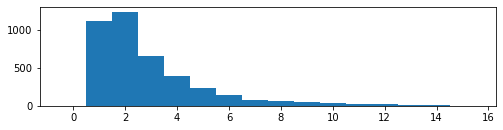

In [60]:
nb_children_histo(gt3)

# problèmes/questions?

In [ ]:
print(leafarea(g,id_n1)) # résultats très élevés
print(leafarea(g,id_n2))
print(leafarea(g,id_n3))

Les diamètres des ucs non taillées sont parfois très gros.

In [ ]:
diam = [(vid,get_gu_diameter(t3,vid)) for vid in get_all_terminal_gus(t3) if sum([vid in l for l in listidprunedT3.values()]) == 0 and not 'A'in t3.property('Taille').get(vid,'')]
hist([d for v,d in diam],range(20))
show()
print([(v,d) for v,d in diam if d > 10])
print(len(diam))
print(len([(v,d) for v,d in diam if d > 12]))

Les **longueurs d'UCs générées** suivent la loi normale du modèle précédent. A corriger avec données 2017

# leaf area produced at the tree scale vs. leaf area removed by pruning

In [ ]:
def leaf_area_produced(mtg,newids):
    newids = growth(t3, listidprunedT3, T3)
    totalleafarea = sum([individual_leafarea_unpruned() for vid in newids])
    growth(t3, listidprunedT3, T3)
    return totalleafarea

# améliorations possibles du modèle

In [ ]:
def pipeline(mtg, nbcuts):
    # characterize before pruning
    # nb of terminal units
    nbterminalunits = len(get_all_terminal_gus(mtg))

    # determine pruning
    listidpruned = define_pruning(mtg, nbcuts)
    #pruningprop = tag_pruning(mtg, listidpruned)

    # characterize pruning
    # - intensity
    intensity = intensity_level(continuous_intensity(g,listidpruned))
    if intensity == T2:
        raise ValueError('Intensity', intensity)
        
    #  - nb of terminal units
    nbremovedGU = sum([sum([len(get_descendants_gus_from_ancestor(mtg, vid))-1 for vid in pruneds]) for order, pruneds in listidpruned.items()])
    
    # - surface foliaire retire 
    removed_leaf_area = sum([sum([gu_leaf_area(get_gu_diameter(mtg, vid)) for vid in pruneds]) for order, pruneds in listidpruned.items()])
    
    # apply pruning
    prunedmtg = deepcopy(mtg)
    apply_pruning(prunedmtg, listidpruned)

    # characterize pruning
    # nb of terminal units
    
    # apply growth    
    growthmtg, newGUs = growth(prunedmtg, listidpruned, intensity)

    allpruned = set(listidpruned[n1]) | set(listidpruned[n2]) | set(listidpruned[n3])

    # characterize growth
    nbgeneratedGU = len(newGUs)
    generated_leaf_area_pruned = sum([la for vid,la in growthmtg.property('RegeneratedLeafArea').items() if vid in allpruned])
    generated_leaf_area_unpruned = sum([la for vid,la in growthmtg.property('RegeneratedLeafArea').items() if not (vid in allpruned)])
    
    return (nbterminalunits, nbremovedGU, nbgeneratedGU), (removed_leaf_area, generated_leaf_area_pruned, generated_leaf_area_unpruned)
    

In [ ]:
units0, la0 = pipeline(g, 0)
print(units0, la0)

In [ ]:
units20, la20 = pipeline(g, 20)
print(units20, la20)

In [ ]:
units60, la60 = pipeline(g, 60)
print(units60, la60)

In [ ]:
#units0060, la0060 = pipeline(g, (0,30,76))
#print(units0060, la0060)

In [ ]:
print(la0[1]-la0[0])
print(la20[1]-la20[0])
print(la60[1]-la60[0])


In [ ]:
def process_range(mtg, cutrange = (0,20), cuttype = (1,1,1), nbtests = 1):
    if type(cutrange) == int:
        cutrange = (0, cutrange)
    import numpy as np
    gla = []
    gunits = [] 
    cuts = []
    for c in range(*cutrange):
        for i in range(nbtests):
            print('process',c,'-',i)
            try:
                units, la = pipeline(mtg, [c*i for i in cuttype])
            except ValueError as e:
                print(e)
                continue
            gla.append(la)
            gunits.append(units)
            cuts.append(c)
    gla = np.array(gla)
    gunits = np.array(gunits)
    return cuts, gla, gunits
    

In [ ]:
cuts76, las76, units76 = process_range(g,(0,76), nbtests = 1)


In [ ]:
def plot_cutrange(cuts, las, units):
    figure(figsize=(12,6))
    #subplot(121)
    normalproduction = np.mean(las[where(np.isin(cuts,[0]))[0],2])
    plot(cuts,las[:,0],'.',label='removed leaf area')
    plot(cuts,las[:,1],'.',label='generated leaf area from pruned GU')
    plot(cuts,las[:,2],'.',label='generated leaf area from unpruned GU')
    plot(cuts,las[:,1]+las[:,2],'.',label='generated leaf area')
    plot(cuts,(las[:,1]+las[:,2])-(las[:,0]+normalproduction),'.',label='increase of leaf area (compared to To)')
    legend()
    show()
    figure(figsize=(12,6))
    #subplot(122)
    plot(cuts,units[:,0],'.',label='nb terminal units')
    plot(cuts,units[:,1],'.',label='nb removed GU')
    plot(cuts,units[:,2],'.',label='nb generated GU')
    legend()
    show()


In [ ]:
plot_cutrange(cuts76, las76, units76)


In [ ]:

cuts, las, units = process_range(g,(0,300,5), cuttype = (1,0,0), nbtests = 1)

In [ ]:
plot_cutrange(cuts, las, units)

In [ ]:
cuts, las, units = process_range(g,(0,300,5), cuttype = (0,1,0), nbtests = 1)

In [ ]:
plot_cutrange(cuts, las, units)

In [ ]:
cuts, las, units = process_range(g,(0,80,2), cuttype = (0,0,1), nbtests = 1)

In [ ]:
plot_cutrange(cuts, las, units)